In [1]:
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting(use_latex=True, pretty_print=False)

# Generalized coordinates

In [2]:
q1, q2, q3 = me.dynamicsymbols('q1, q2, q3')

# Generalized speeds

In [3]:
u1, u2, u3 = me.dynamicsymbols('u1, u2, u3')

# Specified Inputs

In [4]:
F, T = me.dynamicsymbols('F, T')

# Constants

In [5]:
k, c, ma, mb, mc, IB_bo, l, kT, g = sm.symbols('k, c, m_a, m_b, m_c, I_{B_bo}, l, k_T, g')
IB_bo

# Reference Frames

In [6]:
N = me.ReferenceFrame('N')

In [7]:
B = N.orientnew('B', 'Axis', (q2, N.z))

In [8]:
C = B.orientnew('C', 'Axis', (q3, N.z))

# Kinematic Differential Equations

$$
u_i = \dot{q}_i \\
0 = u_i - \dot{q}_i
$$


In [9]:
kdes = [u1 - q1.diff(),
        u2 - q2.diff(),
        u3 - q3.diff()]
kdes

# Angular Velocities

In [10]:
B.set_ang_vel(N, u2 * N.z)

In [11]:
C.set_ang_vel(B, u3 * N.z)

# Points

In [12]:
O = me.Point('O')

In [13]:
Pab = O.locatenew('P_{ab}', q1 * N.x)

In [14]:
Bo = Pab.locatenew('B_o', - 2 * l / 3 * B.y)

In [15]:
Pbc = Pab.locatenew('P_{bc}', -l * B.y)

In [16]:
Pc = Pbc.locatenew('P_c', -l * C.y)

In [17]:
Pc.pos_from(O)

# Linear Velocities

In [18]:
Pab.set_vel(N, u1 * N.x)

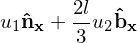

In [19]:
Bo.v2pt_theory(Pab, N, B)

In [20]:
Pbc.v2pt_theory(Pab, N, B)

In [21]:
Pc.v2pt_theory(Pbc, N, C)

# Partial Velocities

In [22]:
Pab.vel(N).diff(u1, N)

In [23]:
Pab.partial_velocity(N, u1)

In [24]:
Pab.partial_velocity(N, u1, u2, u3)

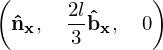

In [25]:
Bo.partial_velocity(N, u1, u2, u3)

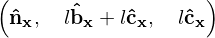

In [26]:
Pc.partial_velocity(N, u1, u2, u3)

In [27]:
B.partial_velocity(N, u1, u2, u3)

In [28]:
[B.ang_vel_in(N).diff(ur, N) for ur in [u1, u2, u3]]

# Angular Accelerations

In [29]:
alpha_B_N = B.ang_acc_in(N)
alpha_B_N

In [30]:
a_Pab_N = Pab.acc(N)
a_Pab_N

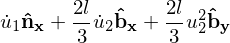

In [31]:
a_Bo_N = Bo.acc(N)
a_Bo_N

In [32]:
a_Pc_N = Pc.acc(N)
a_Pc_N

# Loads (forces and torques)

In [33]:
t = sm.symbols('t')
t = me.dynamicsymbols._t

In [34]:
F

In [35]:
Rab = (F - k * q1 - c * u1) * N.x
Rab

In [36]:
Rbo = -(mb * g) * N.y
Rbo

In [37]:
Rc = -(mc * g) * N.y
Rc

In [38]:
TB = (T + kT * q3) * N.z
TB

# Mass and Inertia

In [39]:
IB = me.inertia(B, 0, 0, IB_bo)
IB

In [40]:
ma, mc

# Particles and Bodies

In [41]:
slider = me.Particle('slider', Pab, ma)
bob = me.Particle('bob', Pc, mc)

In [42]:
pend = me.RigidBody('pend', Bo, B, mb, (IB, Bo))

In [43]:
bodies = [slider, bob, pend]

# Loads (forces and torques)

In [44]:
loads = [(Pab, Rab),
         (Pc, Rc),
         (Bo, Rbo),
         (B, TB)]

In [45]:
q = sm.Matrix([q1, q2, q3])
u = sm.Matrix([u1, u2, u3])

In [46]:
kane = me.KanesMethod(N, q, u, kd_eqs=kdes)

In [47]:
Fr, Frstar = kane.kanes_equations(bodies, loads)

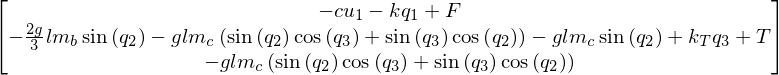

In [48]:
Fr

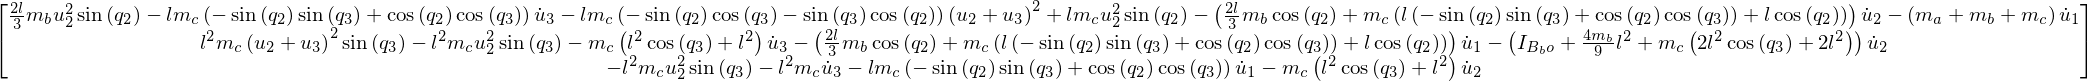

In [49]:
Frstar

# Simulation

In [50]:
import numpy as np
from pydy.system import System

Simulate for 5 seconds and return the values of the states every 5 ms. Use a 1D numpy array to specify this.

In [51]:
times = np.linspace(0.0, 10.0, num=1001)

In [52]:
times

array([  0.  ,   0.01,   0.02, ...,   9.98,   9.99,  10.  ])

In [53]:
times.shape

In [54]:
#System?

Create dictionaries that map numeric values to each symbol in the equations of motion. Make sure your units are consistent!

In [55]:
constants = {l: 1.0,  # meter
             g: 9.81, # meter per second squared
             k: 10.0,  # Newton per meter
             c: 2 * np.sqrt(10.0 * 0.5),  # kilogram second
             kT: 10.0,  # Newton meter per radian
             ma: 0.5,  # kilogram
             mb: 0.5,  # kilogram
             IB_bo: 0.5 * 0.5**2,  # kg m**2
             mc:  0.5}  # meter

# Setting the specified functions of time

In [56]:
# this sets both specified inputs to zero for all time
specifieds = {F: 0.0,
              T: 0.0}

# this sets both specified input to zero for all time
specifieds = {(F, T): np.array([0.0, 0.0])}

# this sets F to sinusoidal forcing with amplitude of 1 N and frequency of 2 * pi rad/s
# and T to zero for all time
def sin_f(x, t):
    """Returns the force F given the state vector x and time value t.
    
    Parameters
    ==========
    x : ndarray, shape(n,)
        The states in the order specified in System.states.
    t : float
        The value of time.
        
    Returns
    =======
    float
        The value of the force at time t.
    
    """
    return 1.0 * np.sin(2 * np.pi * t)


specifieds = {F: sin_f,
              T: 1.0}

# this sets both F and T to sinusoidal forcing
def sin_f_t(x, t):
    return  np.array([0.5 * np.sin(2.0 * np.pi * t),
                      2.0 * np.cos(2.0 * np.pi * t)])


specifieds = {(F, T): sin_f_t}

In [57]:
init_cond = {q1: 0.0,
             q2: 0.0,
             q3: 0.0,
             u1: 0.0,
             u2: 0.0,
             u3: 0.0}


sys = System(kane,
             constants=constants,
             specifieds=specifieds,
             initial_conditions=init_cond,
             times=times
            )

In [58]:
sys.constants

Simulate the system by integrating the equations of motion. `sys.integrate()` returns a 2D NumPy array of the state trajectories.

In [59]:
traj = sys.integrate()

In [60]:
type(traj)

numpy.ndarray

In [61]:
traj.shape

# Plot the state trajectories

In [62]:
import matplotlib.pyplot as plt

The following line enables interactive notebook plotting.

In [63]:
%matplotlib notebook

<IPython.core.display.Javascript object>


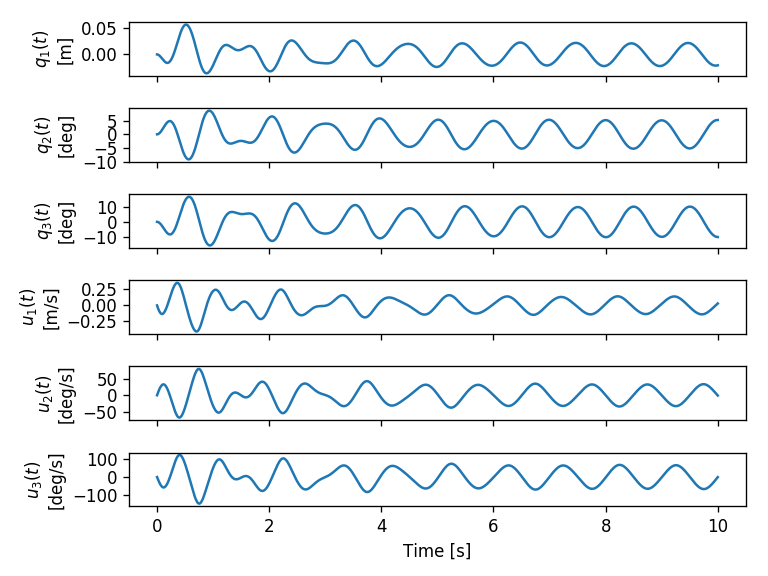

In [64]:
x = [q1, q2, q3, u1, u2, u3]
units = ['m', 'deg', 'deg', 'm/s', 'deg/s', 'deg/s']

# lambda functions to do quick unit conversions
convert = [lambda x: x,
           lambda x : np.rad2deg(x),
           lambda x: np.rad2deg(x),
           lambda x: x,
           lambda x : np.rad2deg(x),
           lambda x: np.rad2deg(x),
          ]

fig, axes = plt.subplots(6, 1, sharex=True)

for i in range(6):
    axes[i].plot(sys.times, convert[i](traj[:, i]))
    axes[i].set_ylabel(sm.latex(x[i], mode='inline') + '\n[' + units[i] + ']')
    
axes[-1].set_xlabel('Time [s]')

plt.tight_layout()